In [6]:
import psutil
print("Instance Memory (GB): %0.2f" % (psutil.virtual_memory().total/2.**30))
print("Available Memory (GB): %0.2f" % (psutil.virtual_memory().available/2.**30))
print("CPU Count: %d" % psutil.cpu_count())

Instance Memory (GB): 29.43
Available Memory (GB): 22.49
CPU Count: 16


In [7]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
sns.set(rc={'figure.figsize': (16, 9)})

In [9]:
os.environ['ZIPLINE_ROOT'] = '/home/jovyan/shared/.zipline'

In [10]:
from alphatools.research import run_pipeline, make_quantile_plot, make_factor_plot
from alphatools.ics import Sector, SubIndustry
from alphatools.data import Factory
from alphatools.expression import ExpressionAlpha
from zipline.pipeline.data import USEquityPricing as USEP
from zipline.pipeline.factors import (
    CustomFactor,
    Returns,
    DailyReturns,
    AverageDollarVolume,
    AnnualizedVolatility,
    SimpleMovingAverage
)
from zipline.pipeline import Pipeline

import numpy as np

In [11]:
universe = AverageDollarVolume(window_length=120).top(2000)

In [12]:
mean_reversion = (
    -Returns(mask=universe, window_length=5).
    demean(groupby=SubIndustry()).
    rank().
    zscore()
)

In [13]:
momentum = (
    (Returns(mask=universe, window_length=260) - Returns(mask=universe, window_length=20)).
    rank().
    zscore()
)


In [14]:
st_volatility = (
    AnnualizedVolatility(window_length=20, mask=universe).
    rank().
    zscore()
)

In [15]:
lt_volatility = (
    AnnualizedVolatility(window_length=120, mask=universe).
    rank().
    zscore()
)

In [16]:
lt_adv = (
    -AverageDollarVolume(window_length=120, mask=universe).
    rank().
    zscore()
)

In [17]:
class MarketDispersion(CustomFactor):
    inputs = [DailyReturns()]
    window_length = 1
    window_safe = True

    def compute(self, today, assets, out, returns):
        # returns are days in rows, assets across columns
        out[:] = np.sqrt(np.nanmean((returns - np.nanmean(returns))**2))

In [18]:
class MarketVolatility(CustomFactor):
    inputs = [DailyReturns()]
    window_safe = True
    
    def compute(self, today, assets, out, returns):
        mkt_returns = np.nanmean(returns, axis=1)
        out[:] = np.sqrt(260.* np.nanmean((mkt_returns-np.nanmean(mkt_returns))**2))

In [19]:
p = Pipeline(screen=universe)
p.add(mean_reversion, 'st_mean_reversion')
p.add(momentum, 'momentum')
p.add(st_volatility, 'st_volatlity')
p.add(lt_volatility, 'lt_volatlity')
p.add(lt_adv, 'lt_adv')
p.add(MarketVolatility(window_length=120), 'market_volatility')
p.add(SimpleMovingAverage(inputs=[MarketDispersion(mask=universe)], window_length=120), 'dispersion')
p.add(Sector(), 'sector')
#p.add(Returns(window_length=5, mask=universe).demean(groupby=SubIndustry()).rank().zscore(), 'target')
p.add(Returns(window_length=5, mask=universe).rank().zscore(), 'target')

In [20]:
start_date = '2005-01-03'
end_date = '2017-12-28'

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
%%time
df = run_pipeline(p, start_date, end_date)

In [18]:
# shift the target
df['target'] = df.groupby(level=1)['target'].shift(-5)
df['target_c'] = np.where(df['target'] > 1, 1, 0)
df['target_c'] = np.where(df['target'] < -1, -1, df['target_c'])


In [19]:
df['target_c'].min()

-1

In [20]:
# special factor
df['test_factor'] = np.random.normal(scale=2, size=len(df)) + np.where(df['sector']==6, df['target']*0.10, 0)


In [21]:
df['pure_test_factor'] =  np.where(df['sector']==6, df['test_factor'], 0)

In [22]:
df.head()

dispersion    lt_adv  \
2005-01-03 00:00:00+00:00 Equity(0 [A])        0.023478 -1.346670   
                          Equity(6 [AAON])     0.023478  1.459253   
                          Equity(7 [AAP])      0.023478 -1.104183   
                          Equity(8 [AAPL])     0.023478 -1.705204   
                          Equity(11 [ABAX])    0.023478  0.414826   

                                             lt_volatlity  market_volatility  \
2005-01-03 00:00:00+00:00 Equity(0 [A])          0.745648           0.130557   
                          Equity(6 [AAON])       0.395774           0.130557   
                          Equity(7 [AAP])        0.054560           0.130557   
                          Equity(8 [AAPL])       0.908461           0.130557   
                          Equity(11 [ABAX])      1.303368           0.130557   

                                             momentum  sector  \
2005-01-03 00:00:00+00:00 Equity(0 [A])     -1.258848       0   
                          Equity(6 [AAON])  -1.318793       5   
                          Equity(7 [AAP])   -0.615800       2   
                          Equity(8 [AAPL])   1.692996       6   
                          Equity(11 [ABAX]) -1.433234       0   

                                             st_mean_reversion  st_volatlity  \
2005-01-03 00:00:00+00:00 Equity(0 [A])              -0.445798     -0.904997   
                          Equity(6 [AAON])           -1.662013      0.532606   
                          Equity(7 [AAP])            -0.803770     -1.275656   
                          Equity(8 [AAPL])           -0.074485      0.924049   
                          Equity(11 [ABAX])           0.367977      1.299904   

                                               target  target_c  test_factor  \
2005-01-03 00:00:00+00:00 Equity(0 [A])     -0.695418         0     0.936396   
                          Equity(6 [AAON])  -0.264138         0    -1.214075   
                          Equity(7 [AAP])    0.782021         0     0.819463   
                          Equity(8 [AAPL])   1.700008         1    -0.914739   
                          Equity(11 [ABAX]) -1.455789        -1    -0.034469   

                                             pure_test_factor  
2005-01-03 00:00:00+00:00 Equity(0 [A])              0.000000  
                          Equity(6 [AAON])           0.000000  
                          Equity(7 [AAP])            0.000000  
                          Equity(8 [AAPL])          -0.914739  
                          Equity(11 [ABAX])          0.000000

Formatting factor data for: test_factor
Dropped 0.2% entries from factor data: 0.2% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: pure_test_factor
Dropped 0.3% entries from factor data: 0.2% in forward returns computation and 0.2% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 124.23 secs
Time to generate long/short returns: 7.44 secs


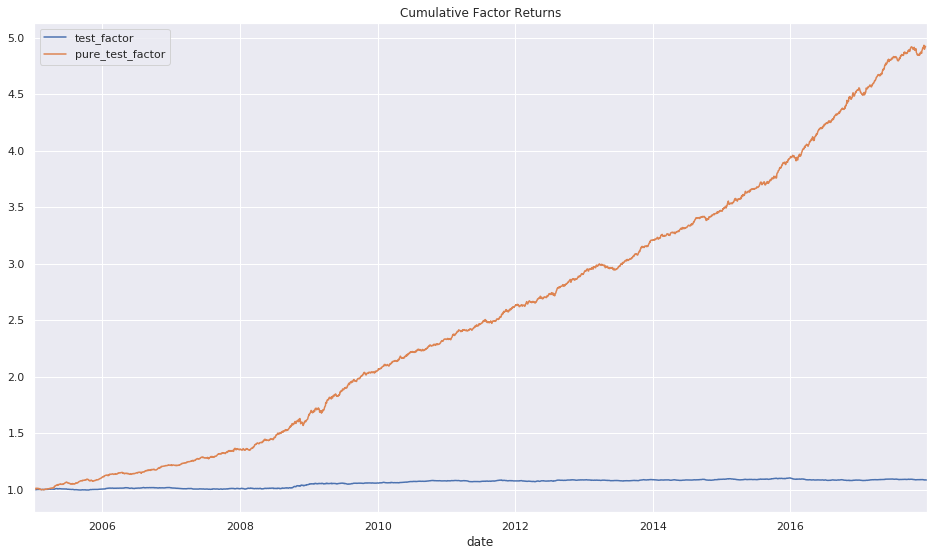

In [23]:
make_factor_plot(df[['test_factor', 'pure_test_factor']], start_date, end_date);

Formatting factor data for: lt_volatlity
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: momentum
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: lt_adv
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: st_mean_reversion
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: st_volatlity
Dropped 0.1%

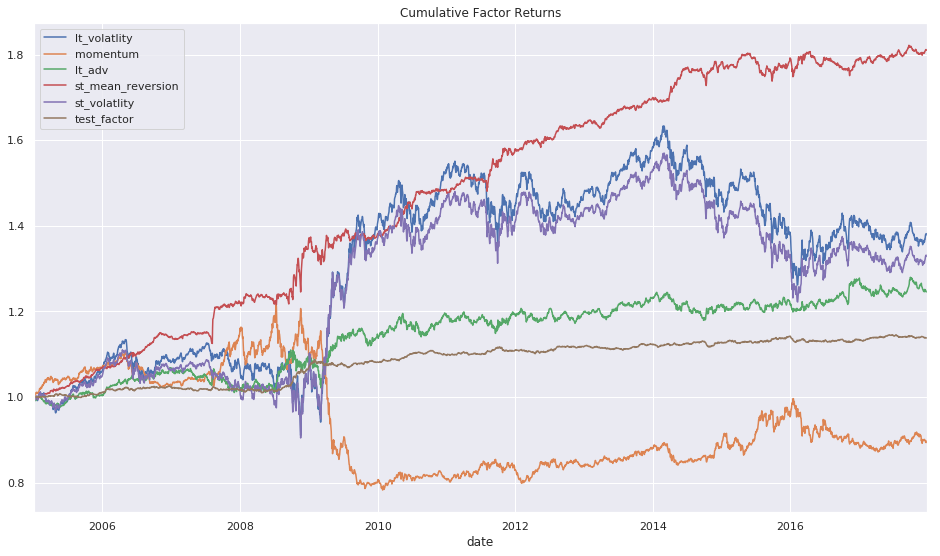

In [24]:
ls = make_factor_plot(df[['lt_volatlity','momentum', 'lt_adv', 'st_mean_reversion', 'st_volatlity', 'test_factor']], start_date, end_date);

In [25]:
end_train = pd.Timestamp('2012-12-31')

In [26]:
def make_train_test_split(X, y, dt_end_train):
    X_train = X.loc[:end_train]
    X_test = X.loc[end_train:]
    y_train = y.loc[:end_train]
    y_test = y.loc[end_train:]
    return X_train, X_test, y_train, y_test

# Traditional (Linear) Model

In [27]:
df_ = df.dropna()

In [28]:
df_.head()

dispersion    lt_adv  \
2005-01-03 00:00:00+00:00 Equity(0 [A])        0.023478 -1.346670   
                          Equity(6 [AAON])     0.023478  1.459253   
                          Equity(7 [AAP])      0.023478 -1.104183   
                          Equity(8 [AAPL])     0.023478 -1.705204   
                          Equity(11 [ABAX])    0.023478  0.414826   

                                             lt_volatlity  market_volatility  \
2005-01-03 00:00:00+00:00 Equity(0 [A])          0.745648           0.130557   
                          Equity(6 [AAON])       0.395774           0.130557   
                          Equity(7 [AAP])        0.054560           0.130557   
                          Equity(8 [AAPL])       0.908461           0.130557   
                          Equity(11 [ABAX])      1.303368           0.130557   

                                             momentum  sector  \
2005-01-03 00:00:00+00:00 Equity(0 [A])     -1.258848       0   
                          Equity(6 [AAON])  -1.318793       5   
                          Equity(7 [AAP])   -0.615800       2   
                          Equity(8 [AAPL])   1.692996       6   
                          Equity(11 [ABAX]) -1.433234       0   

                                             st_mean_reversion  st_volatlity  \
2005-01-03 00:00:00+00:00 Equity(0 [A])              -0.445798     -0.904997   
                          Equity(6 [AAON])           -1.662013      0.532606   
                          Equity(7 [AAP])            -0.803770     -1.275656   
                          Equity(8 [AAPL])           -0.074485      0.924049   
                          Equity(11 [ABAX])           0.367977      1.299904   

                                               target  target_c  test_factor  \
2005-01-03 00:00:00+00:00 Equity(0 [A])     -0.695418         0     0.936396   
                          Equity(6 [AAON])  -0.264138         0    -1.214075   
                          Equity(7 [AAP])    0.782021         0     0.819463   
                          Equity(8 [AAPL])   1.700008         1    -0.914739   
                          Equity(11 [ABAX]) -1.455789        -1    -0.034469   

                                             pure_test_factor  
2005-01-03 00:00:00+00:00 Equity(0 [A])              0.000000  
                          Equity(6 [AAON])           0.000000  
                          Equity(7 [AAP])            0.000000  
                          Equity(8 [AAPL])          -0.914739  
                          Equity(11 [ABAX])          0.000000

In [29]:
X = df_[['lt_volatlity','momentum', 'lt_adv', 'st_mean_reversion', 'st_volatlity', 'test_factor']]
y = df_['target']
X_train, X_test, y_train, y_test = make_train_test_split(X, y, end_train)

In [30]:
from scipy.optimize import nnls

In [31]:
X.columns

Index(['lt_volatlity', 'momentum', 'lt_adv', 'st_mean_reversion',
       'st_volatlity', 'test_factor'],
      dtype='object')

In [32]:
X_train.shape

(3014681, 6)

In [33]:
mod = nnls(X_train, y_train)

In [34]:
mod

(array([ 0.        ,  0.01114115,  0.        ,  0.01234729,  0.        ,
         0.00213843]), 1707.7322399408586)

In [35]:
wgts = mod[0]

In [36]:
preds = X.dot(wgts)

In [37]:
df_linear = pd.DataFrame(index=preds.index, data=preds.values, columns=['linear_mod'])

Formatting factor data for: linear_mod
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 48.66 secs
Time to generate long/short returns: 3.49 secs


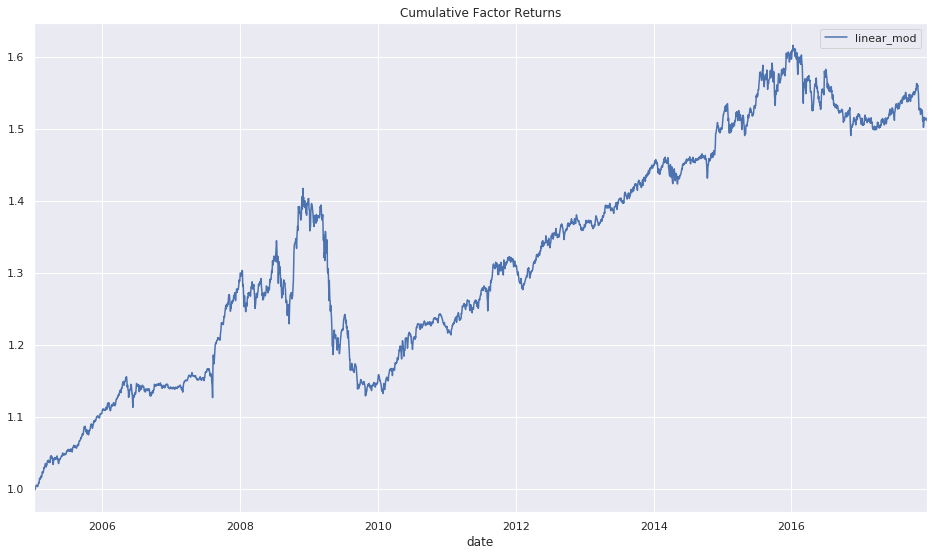

In [38]:
make_factor_plot(df_linear, start_date, end_date);

# Machine Learning Model

In [39]:
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

In [40]:
df_ = pd.concat([df.drop(['sector'], axis=1),pd.get_dummies(df['sector'])], axis=1)

In [41]:
df_ = df_.dropna()

In [42]:
df_ = df_[~(df_['target_c']==0)]

In [43]:
df['target_c'].min()

-1

In [44]:
df_.columns

Index([       'dispersion',            'lt_adv',      'lt_volatlity',
       'market_volatility',          'momentum', 'st_mean_reversion',
            'st_volatlity',            'target',          'target_c',
             'test_factor',  'pure_test_factor',                  -1,
                         0,                   1,                   2,
                         3,                   4,                   5,
                         6,                   7,                   8],
      dtype='object')

In [45]:
features = [
    'dispersion', 'market_volatility', 'lt_volatlity','momentum', -1, 0, 1, 2, 3, 4, 5, 6, 7, 8, 'lt_adv', 'st_mean_reversion', 'st_volatlity', 'test_factor'
]
X = df_[features]
y = df_['target_c']
X_train, X_test, y_train, y_test = make_train_test_split(X, y, end_train)

In [46]:
X_train.columns

Index([       'dispersion', 'market_volatility',      'lt_volatlity',
                'momentum',                  -1,                   0,
                         1,                   2,                   3,
                         4,                   5,                   6,
                         7,                   8,            'lt_adv',
       'st_mean_reversion',      'st_volatlity',       'test_factor'],
      dtype='object')

In [47]:
y.max()

1

In [48]:
X_train.shape

(1230893, 18)

In [49]:
rf = RandomForestClassifier(
    n_estimators=250,
    criterion='entropy',
    min_samples_leaf=20000,
    n_jobs=8,
    verbose=True,
    oob_score=False
)

In [50]:
# rf = ExtraTreesClassifier(
#     n_estimators=1500,
#     criterion='entropy',
#     min_samples_leaf=20000,
#     n_jobs=15,
#     verbose=True,
#     oob_score=False
# )

In [51]:
%%time
ml_mod = rf.fit(X_train.values, y_train.values)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:   12.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:  1.0min


CPU times: user 11min 3s, sys: 4.2 s, total: 11min 7s
Wall time: 1min 25s


[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:  1.4min finished


In [52]:
preds = ml_mod.predict_proba(X)

[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:    0.7s
[Parallel(n_jobs=8)]: Done 184 tasks      | elapsed:    3.3s
[Parallel(n_jobs=8)]: Done 250 out of 250 | elapsed:    4.4s finished


In [53]:
preds=preds.dot(np.array([-1,1]))

In [54]:
ml_mod.feature_importances_

array([ 0.11624865,  0.16349964,  0.11891829,  0.16321603,  0.        ,
        0.00852961,  0.05938362,  0.00428374,  0.04090833,  0.00232494,
        0.00971624,  0.00100196,  0.        ,  0.        ,  0.03043415,
        0.15926316,  0.10942204,  0.01284961])

In [55]:
X_train.columns

Index([       'dispersion', 'market_volatility',      'lt_volatlity',
                'momentum',                  -1,                   0,
                         1,                   2,                   3,
                         4,                   5,                   6,
                         7,                   8,            'lt_adv',
       'st_mean_reversion',      'st_volatlity',       'test_factor'],
      dtype='object')

In [56]:
from IPython.display import Image

In [57]:
import graphviz
from sklearn.tree import export_graphviz

dot_data = export_graphviz(
    ml_mod.estimators_[4],
    out_file=None,
    feature_names=X.columns,
    filled=True, rounded=True,
    special_characters=True,
    rotate=True
)
#graph = graphviz.Source(dot_data, format='png')

In [58]:
import pydotplus
pydot_graph = pydotplus.graph_from_dot_data(dot_data)

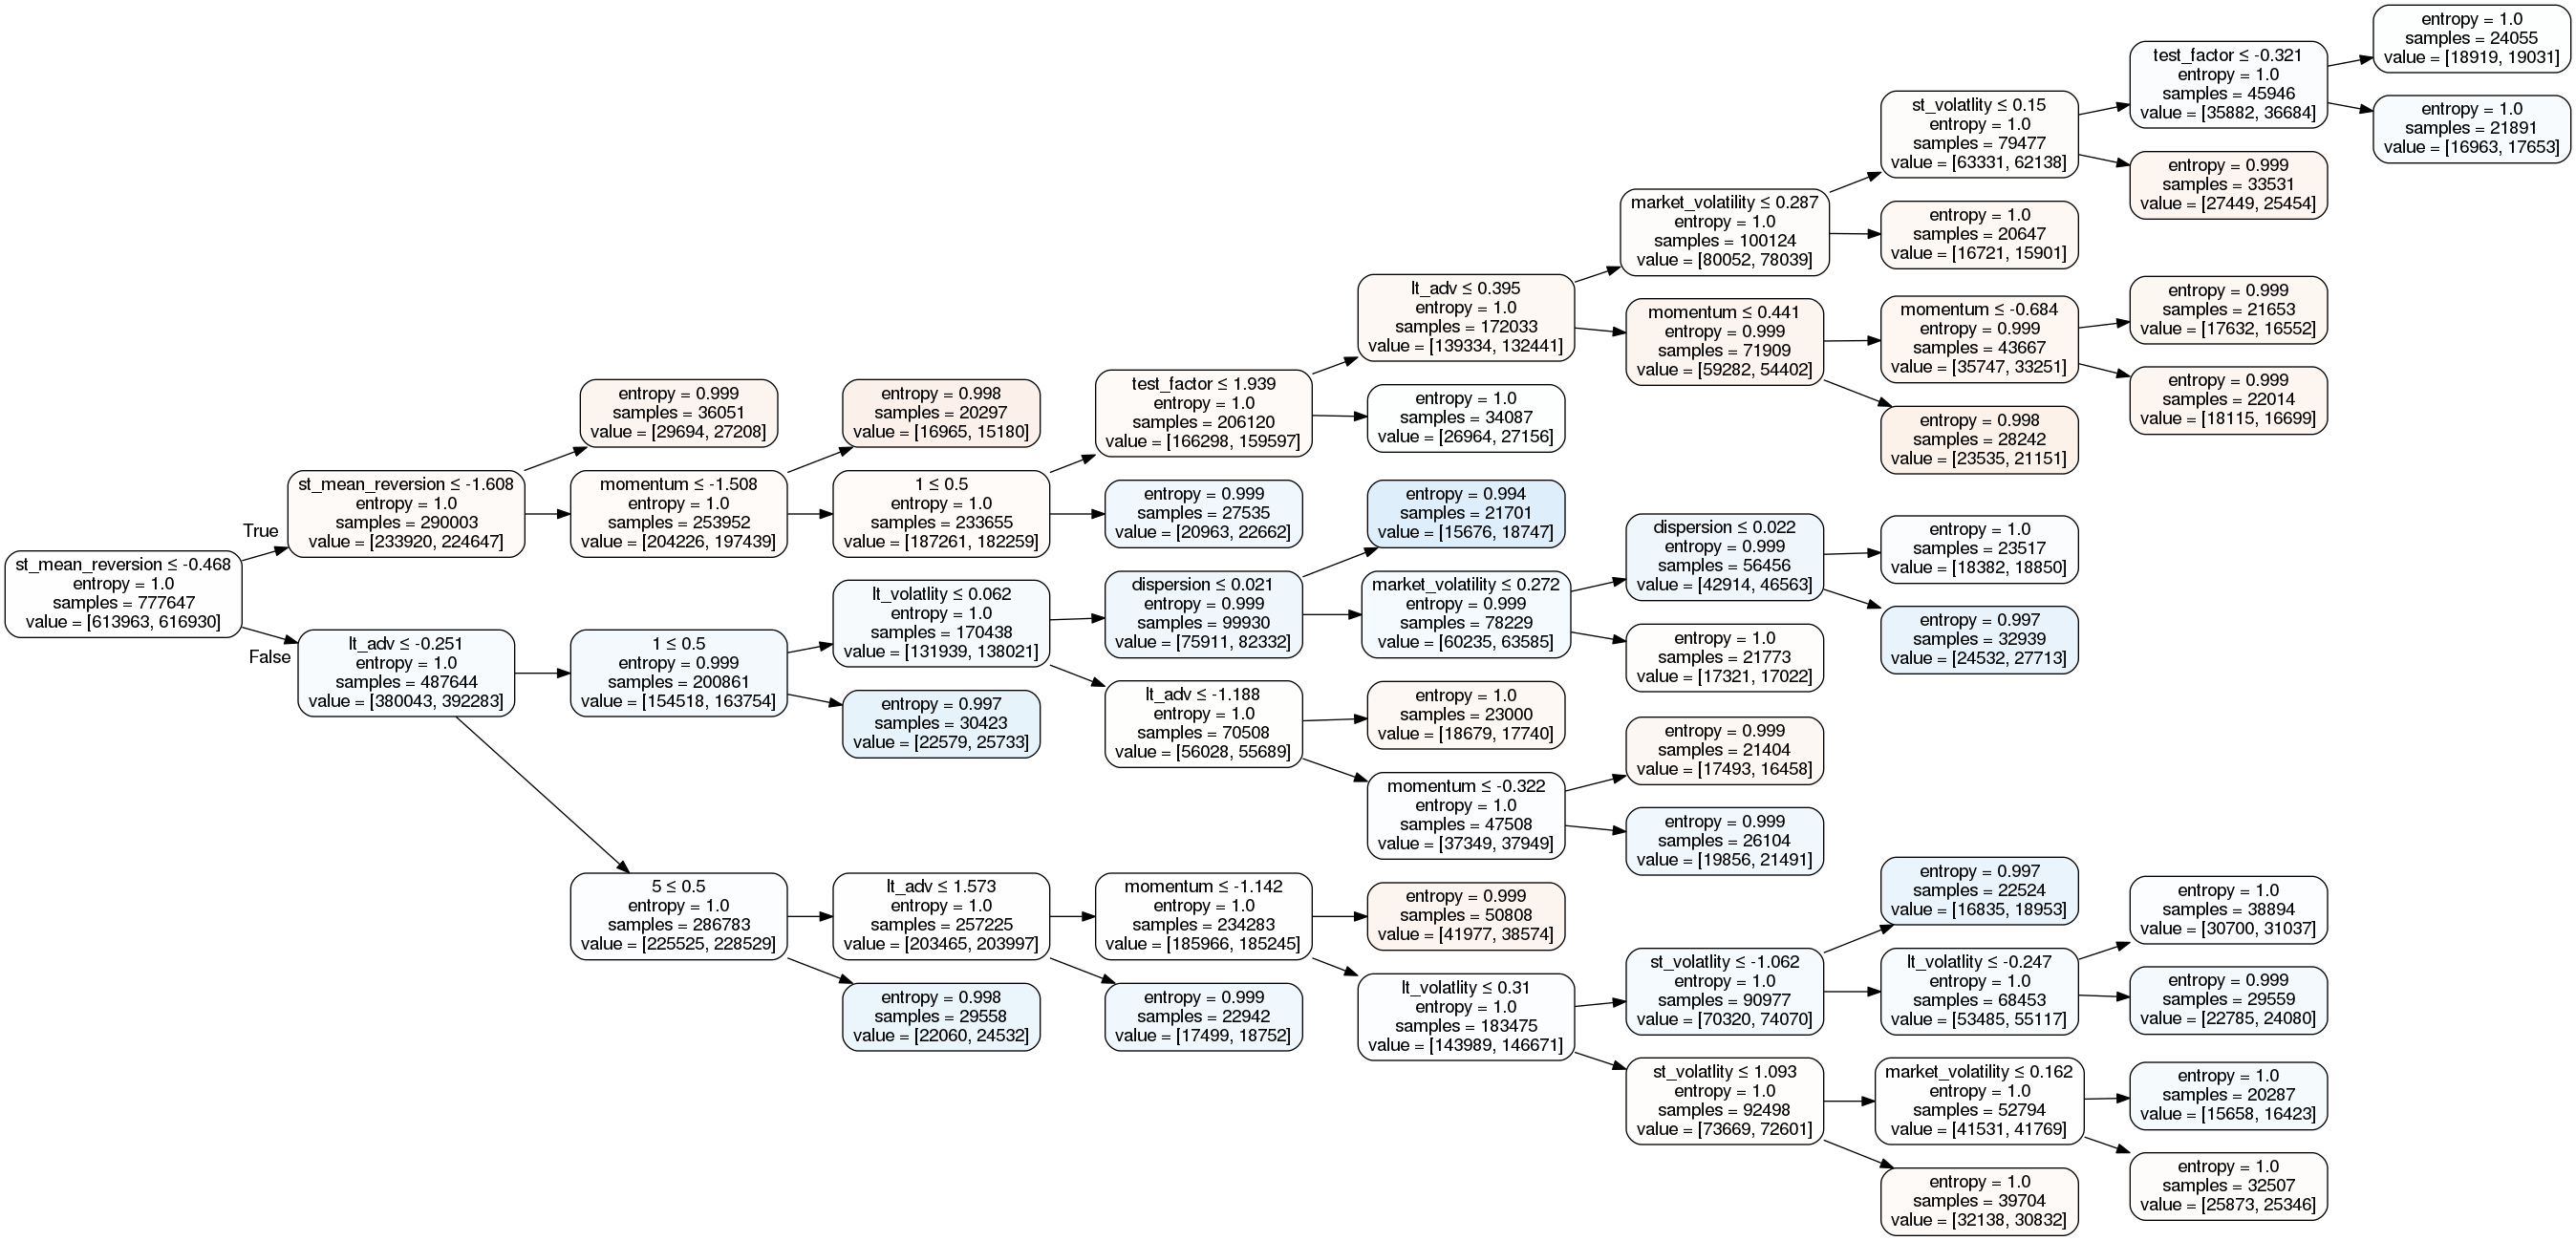

In [59]:
from IPython.display import Image
Image(pydot_graph.create_png())

In [60]:
def model_importances(m, features):
    importances = m.feature_importances_
    indices = np.argsort(importances)[::-1]
    for f in range(X_train.shape[1]):
        print("%d. %s (%d) (%f)" % (f+1,features[indices[f]], indices[f], importances[indices[f]]))

In [61]:
model_importances(ml_mod, features)

1. market_volatility (1) (0.163500)
2. momentum (3) (0.163216)
3. st_mean_reversion (15) (0.159263)
4. lt_volatlity (2) (0.118918)
5. dispersion (0) (0.116249)
6. st_volatlity (16) (0.109422)
7. 1 (6) (0.059384)
8. 3 (8) (0.040908)
9. lt_adv (14) (0.030434)
10. test_factor (17) (0.012850)
11. 5 (10) (0.009716)
12. 0 (5) (0.008530)
13. 2 (7) (0.004284)
14. 4 (9) (0.002325)
15. 6 (11) (0.001002)
16. -1 (4) (0.000000)
17. 7 (12) (0.000000)
18. 8 (13) (0.000000)


In [62]:
df_ml = pd.DataFrame(index=X.index, data=preds, columns=['ml_model'])

In [63]:
df_ml.tail()

ml_model
2017-12-20 00:00:00+00:00 Equity(3181 [ZBRA])  0.045580
                          Equity(3184 [ZEUS])  0.002069
                          Equity(3185 [ZGNX]) -0.048488
                          Equity(3189 [ZIOP]) -0.041503
                          Equity(3195 [ZOES]) -0.041894

In [68]:
df_comb = pd.concat([df_ml, df_linear], axis=1)

Formatting factor data for: ml_model
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Formatting factor data for: linear_mod
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Time to get arrange factor data: 62.64 secs
Time to generate long/short returns: 1.80 secs


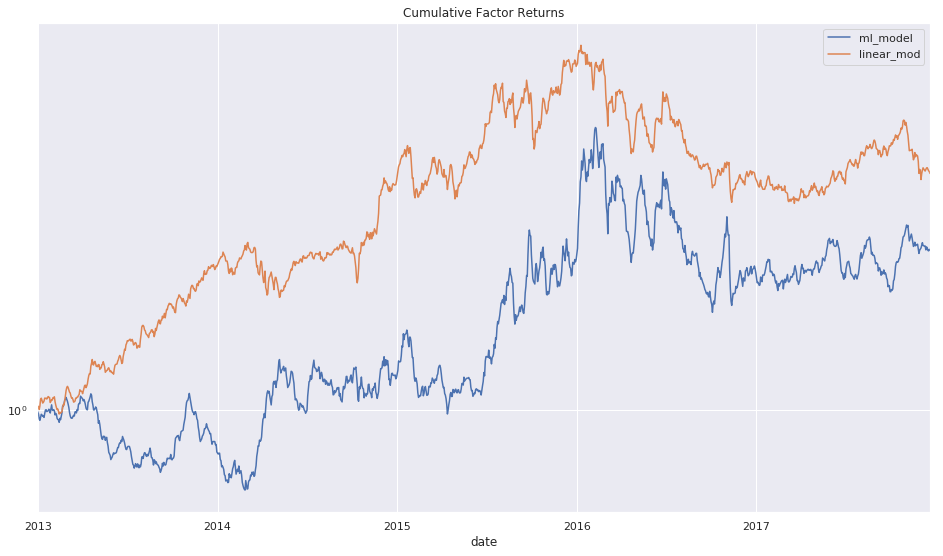

In [70]:
ls_rets = make_factor_plot(df_comb[end_train:], start_date, end_date);
plt.yscale('log')

In [ ]:
16*ls_rets.mean()/ls_rets.std()

In [ ]:
df['sector'].value_counts()

In [ ]:
len(df)

In [ ]:
#!pip install -e alphatools

In [ ]:
import sys

In [ ]:
print(sys.version)